In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch
import pandas as pd
import numba
from skopt import dump, load

In [79]:

def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]
    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    zm = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)
    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    return P

#@numba.jit
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:]


In [67]:

def fb_local_nonvec(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]
    #vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    #wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    zm = forward_backward_nonvec_local(S_exp, T, go, ge, pre)
    zm_hat = forward_backward_nonvec_local(S_hat, T, go, ge, pre)
    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    return P

@numba.jit
def forward_backward_nonvec_local(S, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum
        for j in range(1,S.shape[1]+1):
            ze[i,j] = ze[i,j-1] * exp_go + zm[i,j-1] * exp_ge
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:]

In [68]:
time_nonvec_jit = []
for size in (range(50, 1501, 50)):
    print(size)
    S = np.zeros((size,size))-100#(np.random.rand(size,size) - 0.5)
    go, ge = 0,0
    T = 10
    pre = np.float64
    fb_local_nonvec(S, go, ge, T, pre)
    start = time.time()
    for i in range(50):
        fb_local_nonvec(S, go, ge, T, pre)
    time_nonvec_jit.append((time.time() - start)/50)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


In [69]:
time_vec_jit = []
for size in (range(50, 1501, 50)):
    print(size)
    S = np.zeros((size,size))-100#(np.random.rand(size,size) - 0.5)/10
    go, ge = 0, 0.0001
    T = 10
    pre = np.float64
    fb_local(S, go, ge, T, pre)
    start = time.time()
    for i in range(50):
        fb_local(S, go, ge, T, pre)
    time_vec_jit.append((time.time() - start)/50)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500


In [80]:
time_vec = []
for size in (range(50, 501, 50)):
    print(size)
    S = np.random.rand(size,size)
    go, ge= .1, 0.01
    T = 10
    pre = np.float64
    start = time.time()
    for i in range(50):
        fb_local(S, go, ge, T, pre)
    time_vec.append((time.time() - start)/50)

50
100
150
200
250
300
350
400
450
500


In [78]:
time_vec

[0.002282099723815918,
 0.0029530715942382812,
 0.00525146484375,
 0.006733784675598145,
 0.009105782508850097,
 0.010848722457885741,
 0.013687338829040527,
 0.016579885482788086,
 0.019670076370239258,
 0.023295326232910155,
 0.029088292121887207,
 0.03527926921844483,
 0.04103107452392578,
 0.047587070465087894,
 0.052940931320190426,
 0.0611568546295166,
 0.06612881183624268,
 0.07412365913391113,
 0.08017217636108398,
 0.0895619535446167,
 0.09104870319366455,
 0.1023246717453003,
 0.13394464492797853,
 0.14289687633514403,
 0.14606552600860595,
 0.16208669185638427,
 0.16846951961517334,
 0.17842700481414794,
 0.192643723487854,
 0.20332088947296142]

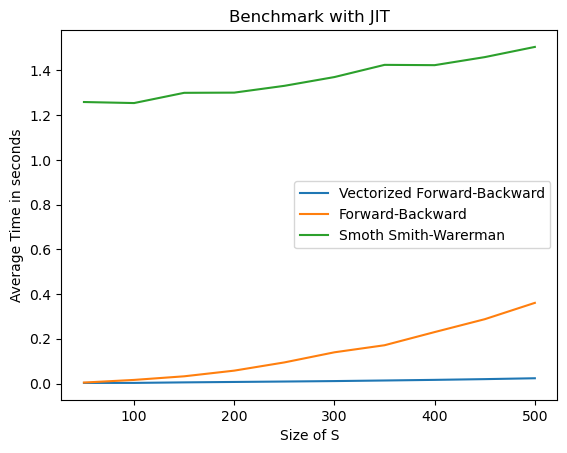

In [81]:
plt.plot(range(50, 501, 50), time_vec, label = 'Vectorized Forward-Backward')
plt.plot(range(50, 501, 50), time_nonvec, label = 'Forward-Backward')
plt.plot(range(50, 501, 50), time_ssw, label = 'Smoth Smith-Warerman')
plt.title('Benchmark with JIT')
plt.xlabel('Size of S')
plt.ylabel('Average Time in seconds')
plt.legend()

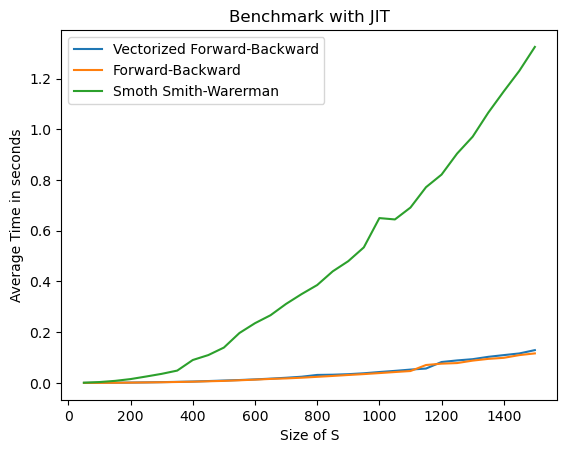

In [73]:
plt.plot(range(50, 1501, 50), time_vec_jit, label = 'Vectorized Forward-Backward')
plt.plot(range(50, 1501, 50), time_nonvec_jit, label = 'Forward-Backward')
#plt.plot(range(50, 501, 50), time_ssw, label = 'ssw')
plt.plot(range(50, 1501, 50), time_ssw_jit, label = 'Smoth Smith-Warerman')
#plt.plot(range(50, 501, 50), time_ssw_jit, label = 'ssw_jit')
plt.title('Benchmark with JIT')
plt.xlabel('Size of S')
plt.ylabel('Average Time in seconds')
plt.legend()

In [7]:
import jax
import jax.numpy as jnp

def sw_affine(restrict_turns=True, 
             penalize_turns=True,
             batch=True, unroll=2, NINF=-1e30):
    """smith-waterman (local alignment) with affine gap"""
    # rotate matrix for vectorized dynamic-programming  

    def rotate(x):   
        # solution from jake vanderplas (thanks!)
        a,b = x.shape
        ar,br = jnp.arange(a)[::-1,None], jnp.arange(b)[None,:]
        i,j = (br-ar)+(a-1),(ar+br)//2
        n,m = (a+b-1),(a+b)//2
        output = {"x":jnp.full([n,m],NINF).at[i,j].set(x), "o":(jnp.arange(n)+a%2)%2}
        return output, (jnp.full((m,3), NINF), jnp.full((m,3), NINF)), (i,j)

    # fill the scoring matrix
    def sco(x, lengths, gap=0.0, open=0.0, temp=1.0):

        def _soft_maximum(x, axis=None, mask=None):
            def _logsumexp(y):
                y = jnp.maximum(y,NINF)
                if mask is None: return jax.nn.logsumexp(y, axis=axis)
                else: return y.max(axis) + jnp.log(jnp.sum(mask * jnp.exp(y - y.max(axis, keepdims=True)), axis=axis))
            return temp*_logsumexp(x/temp)

        def _cond(cond, true, false):
            return cond*true + (1-cond)*false
        def _pad(x,shape):
            return jnp.pad(x,shape,constant_values=(NINF,NINF))
      
        def _step(prev, sm):
            h2,h1 = prev   # previous two rows of scoring (hij) mtxs

            Align = jnp.pad(h2,[[0,0],[0,1]]) + sm["x"][:,None]
            Right = _cond(sm["o"], _pad(h1[:-1],([1,0],[0,0])),h1)
            Down  = _cond(sm["o"], h1,_pad(h1[1:],([0,1],[0,0])))

            # add gap penalty
            if penalize_turns:
                Right += jnp.stack([open,gap,open])
                Down += jnp.stack([open,open,gap])
            else:
                gap_pen = jnp.stack([open,gap,gap])
                Right += gap_pen
                Down += gap_pen

            if restrict_turns:
                Right = Right[:,:2]

            h0_Align = _soft_maximum(Align,-1)
            h0_Right = _soft_maximum(Right,-1)
            h0_Down = _soft_maximum(Down,-1)
            h0 = jnp.stack([h0_Align, h0_Right, h0_Down], axis=-1)
            return (h1,h0),h0

        # mask
        a,b = x.shape
        real_a, real_b = lengths
        mask = (jnp.arange(a) < real_a)[:,None] * (jnp.arange(b) < real_b)[None,:]
        x = x + NINF * (1 - mask)

        sm, prev, idx = rotate(x[:-1,:-1])
        hij = jax.lax.scan(_step, prev, sm, unroll=unroll)[-1][idx]

        # sink
        return _soft_maximum(hij + x[1:,1:,None], mask=mask[1:,1:,None])

    # traceback to get alignment (aka. get marginals)
    traceback = jax.grad(sco)

    # add batch dimension
    if batch: return jax.vmap(traceback,(0,0,None,None,None))
    else: return traceback, sco

In [9]:
sw_app, _ = sw_affine(restrict_turns=False, batch=False)

true_len = (50, 50)
scores = np.random.rand(*true_len)  # random similarity scores

P = sw_app(scores, size, gap=-.1, open=-1, temp=10.0)

TypeError: cannot unpack non-iterable int object

In [10]:
time_ssw=[]
for size in (range(50, 501, 50)):
    print(size)
    length = (size,size)
    S = np.random.rand(*length) -0.5
    sw_app(scores, length, gap=-.1, open=-1, temp=10.0)
    start = time.time()
    for i in range(50):
        sw_app(S, length, gap=-.1, open=-1, temp=10.0)
    time_ssw.append((time.time() - start)/50)
    

50
100
150
200
250
300
350
400
450
500


In [28]:
time_ssw_jit=[]
sw_app_jit = jax.jit(sw_app)
for size in (range(50, 1501, 50)):
    print(size)
    length = (size,size)
    S = np.random.rand(*length) -0.5
    sw_app_jit(scores, length, gap=-.1, open=-1, temp=10.0)
    start = time.time()
    for i in range(50):
        sw_app_jit(S, length, gap=-.1, open=-1, temp=10.0)
    time_ssw_jit.append((time.time() - start)/50)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
